# Imports

In [1]:
# Path hack.
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
import pickle
import torch
from torch.nn import functional as F
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from rdkit import Chem
from molvs import validate_smiles
from src.utils import *
from src.models import *
from src.models.predictor import Predictor
from src.models.generatorLSTM import LSTMGenerator

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

# Loading Models

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
!ls ../models/checkpoints/joint_PARAMS

losses-00005.pkl  losses-00025.pkl  model-00005.pt  model-00025.pt
losses-00010.pkl  losses-02000.pkl  model-00010.pt  model-02000.pt
losses-00015.pkl  losses-04000.pkl  model-00015.pt  model-04000.pt
losses-00020.pkl  losses-06000.pkl  model-00020.pt  model-06000.pt


In [5]:
#MODIFY THESE PARAMETERS
predictorFile = "../models/checkpoints/LogP Predictor/model-300000.pt"
generatorFile = "../models/checkpoints/joint_PARAMS/model-06000.pt"

g_dict = torch.load(generatorFile, map_location=device)
p_dict = torch.load(predictorFile, map_location=device)

In [6]:
#Load generator
G_tokenizer = g_dict['tokenizer']
vocabulary={v:k for k,v in G_tokenizer.word_index.items()}
V = len(vocabulary)
G = LSTMGenerator(vocabulary, vocab_size=V + 2, embedding_dim=32)
G.load_state_dict(g_dict['generator_dict'])
G.to(device)

#Load predictor
P_tokenizer = p_dict['tokenizer']
P = Predictor(vocab_size=V, embedding_dim=32)
P.load_state_dict(p_dict['model_state_dict'])
P.to(device)

Predictor(
  (embedding): Linear(in_features=36, out_features=32, bias=False)
  (position): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoderLayer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): Linear(in_features=32, out_features=32, bias=True)
    )
    (linear1): Linear(in_features=32, out_features=128, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=128, out_features=32, bias=True)
    (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=128

# Evaluation Functions

In [8]:
def generateSmiles(model, num, vocabulary, device):
    max_len = 75
    smiles = []

    #Create mask to prevent attending to future positions
    mask = create_mask(max_len - 1, device)

    for _ in range(num):
        #Create initial token
        curr = torch.zeros((max_len - 1, 1, len(vocabulary) + 2)).to(device)
        curr[0][0][len(vocabulary)] = 1
        current_smile = ""

        for i in range(1, max_len - 1):
            output = torch.softmax(model(curr), dim=2)[i, 0, :].squeeze().to(device)
            prob = torch.distributions.Categorical(output)
            sample = prob.sample().item()
            while sample == len(vocabulary):
                sample = prob.sample().item()
            if sample == len(vocabulary) + 1:
                break
            #Update current smile string and curr tensor
            current_smile += vocabulary[sample + 1]
            curr[i][0][sample] = 1
        if _ % 1 == 0:
            print(current_smile)
        smiles.append(current_smile)

    return smiles

def checkValidity(smiles):
    validSmiles = []
    numWrong = 0
    for s in smiles:
        test = Chem.MolFromSmiles(s)
        if test != None:
            validSmiles.append(s)
        else:
            numWrong += 1
    percentValid = (float(len(smiles) - numWrong)/float(len(smiles))) * 100
    print("Percentage of Valid Smiles: {}%".format(percentValid))
    return validSmiles

def evaluateLogP(model, tokenizer, smiles, vocab, device):
    logP = []

    base = ""
    for v in vocab.values():
        base += v
    smiles.insert(0, base)

    seq_of_ints = tokenizer.texts_to_sequences(smiles)
    seq_of_ints = torch.LongTensor(pad_sequences(seq_of_ints, padding='post', maxlen=75)).to(device)

    #One hot encode
    X = F.one_hot(seq_of_ints)[1:, :, 1:].transpose(0, 1).type(torch.FloatTensor).to(device)
    logP = model(X) 

    return logP.tolist()

In [10]:
#Evaluate results
smiles = generateSmiles(G, 100, vocabulary, device)
validSmiles = checkValidity(smiles)
logP = evaluateLogP(P, P_tokenizer, validSmiles, vocabulary, device=device)

CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

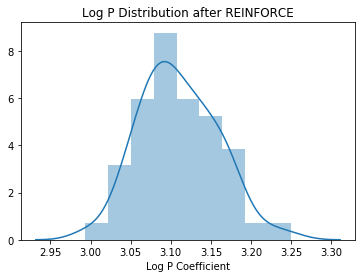

In [12]:
sns.distplot(logP)
plt.title("Log P Distribution after REINFORCE")
plt.xlabel("Log P Coefficient")
plt.savefig("logp_post_reinforce.png")